# Best Video Game Analysis

**Note:**  
If you are receiving this project outside of GitHub, you can find the official repository here:  
[GitHub Repository](https://github.com/vlatcata/AI-Machine-Learning/tree/main/Data%20Science/Project%20-%20Best%20Video%20Game%20Analysis)


## 1. Abstract

**Context:**  
The video game industry is huge, with thousands of games released every year. Only a small part of them manage to become popular and keep players engaged. Finding out what makes these games successful can help both developers and players.  

**Aims:**  
The goal of this project is to build a **Best Game Index (BGI)** that combines several factors into one score, showing which games stand out.  

**Methods:**  
I first built a custom scraper to collect data from the **Steam API** and **SteamSpy API**, but due to strict request limits it was too slow to use directly. Instead, I used a ready dataset with the same information. From it, I created new features like a *review score* (that gives more weight to positive reviews) and a *playtime score*. All features were normalized to be on the same scale. A weighted formula was then used to calculate the BGI. To test if my weights were reliable, I added random noise and checked if the top games stayed the same.  

**Results:**  
Most games in the dataset perform poorly, while only a few dominate in ownership, playtime, and community engagement. The BGI proved stable: even after adding noise to the weights, the top-10 list of games stayed about 90% the same. This shows the index is not too dependent on exact weight choices and works well to highlight the most successful games.  

### 2. Introduction: In this project, we will be trying to determine which is the best video game ever. (Released on steam)

In this project, we aim to determine which is the best video game released on Steam. Since it would be impossible to analyze every game ever created, we will focus on Steam, one of the largest digital platforms for PC games. The dataset we are using contains games going back to 1997 and includes around 200,000 entries — a sufficiently large sample for meaningful analysis.

Our goal is to rank these games based on statistics, taking into account factors like playtime, reviews, achievements, and ownership.

### 3. Data preperation / Cleaning: 
While searching for a clean, up to date dataset I realized there are none, so I tried to create my own using the Steam API with a combination of the Steam SPY API _(src/scraper.py)_. Unfortunately due to those API's having rate limits, a lot of uneeded (for us) data about trailers, DLC's, limitations and data hidden behind a paywall (for Steam SPY) I was unable to create my own dataset. I used the best one I could find which was a dataset from Kaggle, it faced the same issues as me so there is missing data for some games and features. But as Data Scientists we work with what we have.

As mentioned, the sources the dataset creator used, are the same ones I tried to use:
- Steam API has the official MetaData (release data, price, developers)
- Steam Spy has estimated/publically scraped data (owners, playtime, achivements)
- [Kaggle Dataset](https://www.kaggle.com/datasets/fronkongames/steam-games-dataset/data) - place the dataset in the /data folder.

For the helper files to be seen by the interpreter run ```pip install -e .``` and restart the kernel.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px

import src.utils as utils

In [3]:
# Setting the display.max_columns so I can see all columns in the DataFrame
pd.set_option('display.max_columns', None)
# Assuming you already placed the dataset in the /data folder.
games = utils.read_games_csv_with_broken_header("../data/games.csv")

# I added a header 'test' since the dataset was missing one, which caused issues when loading the data. The data for that header is 98% zeroes and since I got no idea what it is, I will
# remove it.
games.drop(columns=['test'], inplace=True)

# turn column names to snake case so it's easier to work with and I won't have to deal with spaces
games.columns = games.columns.str.lower().str.replace(' ', '_')

# The dataset has a lot of empty duplicates so I will get the valid one for each game
games = games.loc[
    games.groupby('name')['median_playtime_forever'].idxmax()
]

# Deserialize release_date into separate columns
games['release_date'] = pd.to_datetime(games['release_date'], errors='coerce')

games['release_year'] = games['release_date'].dt.year
games['release_month'] = games['release_date'].dt.month
games['release_day'] = games['release_date'].dt.day

# Handle missing values and convert to int (from float)
games['release_year'] = games['release_year'].fillna(2025).astype(int) 
games['release_month'] = games['release_month'].fillna(1).astype(int)
games['release_day'] = games['release_day'].fillna(1).astype(int)

# I will drop the user_score because most of the data has 0 due to unavailable statistics, not because the score is 0. This will introduce a huge bias later if kept in.
games.drop(columns=['release_date', 'user_score'], inplace=True)

# Now, I will convert the bool values into numerical ones for easier analysis
bool_columns = games.select_dtypes(include=['bool']).columns
games[bool_columns] = games[bool_columns].astype(int)

# I will create columns for number of entries where we have an array of categories (ex: tags, genres, etc.)
games['num_supported_languages'] = games.supported_languages.fillna('').str.split(',').apply(utils.get_string_array_length)
games['num_supported_audio_languages'] = games.full_audio_languages.fillna('').str.split(',').apply(utils.get_string_array_length)
games['num_tags'] = games.tags.fillna('').str.split(',').apply(utils.get_string_array_length)
games['num_genres'] = games.genres.fillna('').str.split(',').apply(utils.get_string_array_length)
games['num_categories'] = games.categories.fillna('').str.split(',').apply(utils.get_string_array_length)
games.head(5)

games = games.rename(columns={'peak_ccu': 'peak_concurrent_users'})

# I will also normalize the estimated_owners column so we can actually use the data. Will use the formula x_standard = (x - mean) / std
games['owners_count'] = games.estimated_owners.apply(utils.range_to_average)

# Save cleaned dataset
games.to_csv('../data/games_cleaned.csv', index=False)

### 4. Data Visualization

Let's visualize what we have so far.

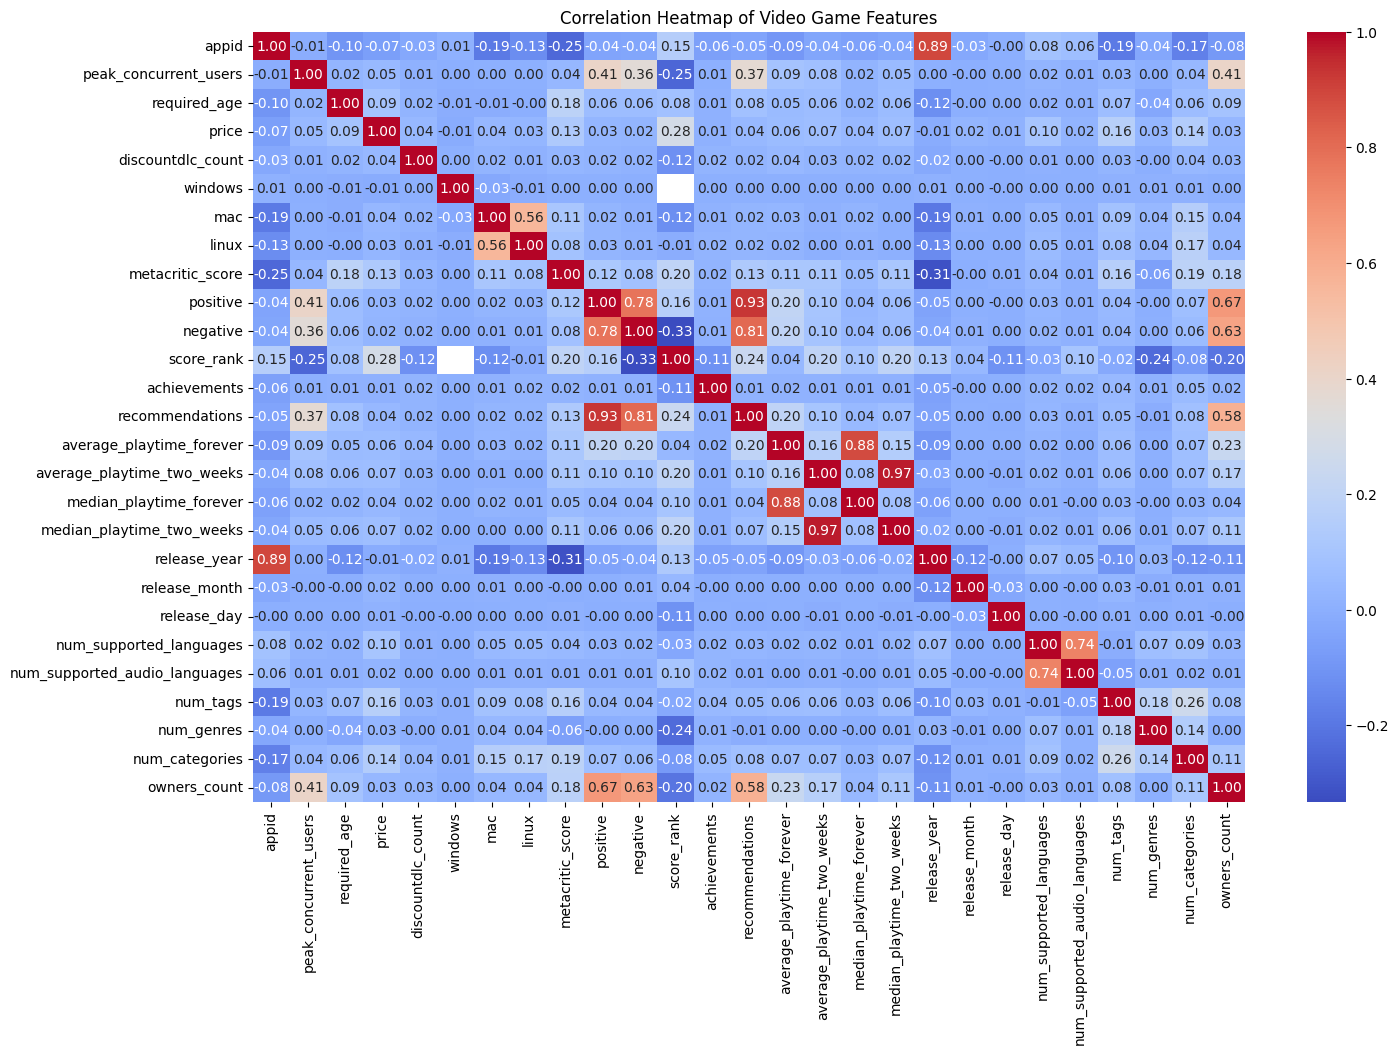

In [4]:
# Now let's display a correlation matrix for visualization.
plt.figure(figsize=(16, 10))
sns.heatmap(games.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Video Game Features')
plt.show()

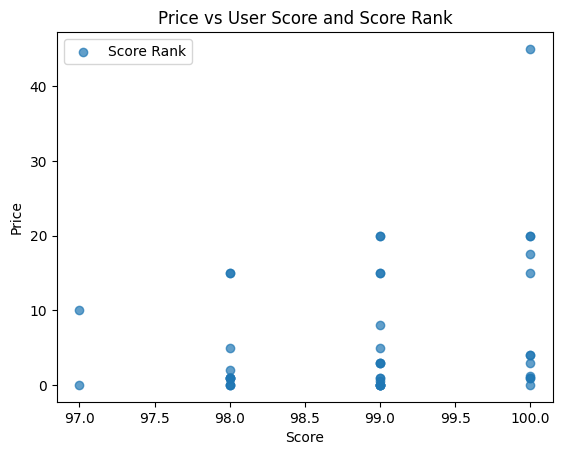

In [5]:
# The price has a positive correlation to the score_rank, as we can see, the more expensive the game, the higher the score.
# Meaning the best games are usually the most expensive ones. (let's keep that in mind)
plt.scatter(games['score_rank'], games['price'], label='Score Rank', alpha=0.7)

plt.xlabel('Score')
plt.ylabel('Price')
plt.title('Price vs User Score and Score Rank')
plt.legend()
plt.show()

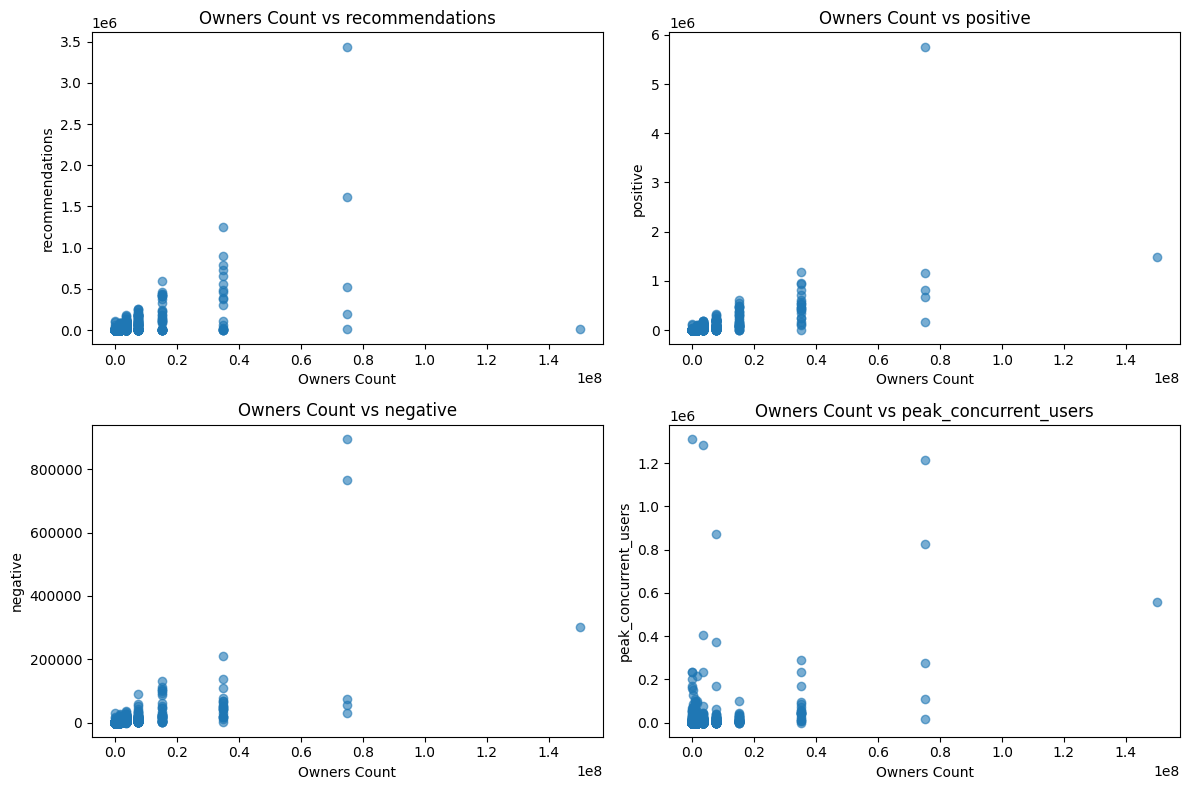

In [6]:
cols = ['recommendations', 'positive', 'negative', 'peak_concurrent_users']

plt.figure(figsize=(12, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    plt.scatter(games['owners_count'], games[col], alpha=0.6)
    plt.xlabel('Owners Count')
    plt.ylabel(col)
    plt.title(f'Owners Count vs {col}')

plt.tight_layout()
plt.show()

# With this plot we can confirm that the more players we have, the more recommendations, positive reviews, negative reviews, and peak concurrent users increase.
# Which is obvious most of the time, but we still need to validate our assumptions with data.

### 5. Feature Engineering

#### I will need a formula to calculate retention score for the games. This will help me formulate the final formula which I will use to determine the best game based on the data from this dataset.

The problem is, the best game is subjective for everyone, some people prefer older games, some newer, some prefer fps, some moba. In order for there to be no bias, I will create a formula, which combines the most important features (high correlation) and calculates a score for each game. But first, I want a retention score feature, which tells us how much of the playerbase stuck around after the initial launch.

Something like $$retention\_score = (avg\_playtime\_2w / avg\_playtime\_forever + 1) * \log(1 + game\_age)$$

We use **log scaling** due to outliers.

Where:
- Close to 1 → people are still playing as much now as ever.
- Close to 0 → game is basically dead.
- We apply an age based weight - $retention\_score * \log(1 + game\_age)$ and use logarithm to normalize the result (boost retention for old games, close to no boost for new games)

In [7]:
# Game age in years (adjust for your dataset year)
games['game_age'] = 2025 - games['release_year']

# Basic retention ratio, adjust by age (log scaling so it doesn’t explode for very old games)
# average_playtime_forever + 1 is to avoid division by zero error
# log1p (1 + log) avoids log(0) issues
games['retention_score'] = (games['average_playtime_two_weeks'] / (games['average_playtime_forever'] + 1) * np.log1p(games['game_age']))

games[games.name.str.contains('Tom Clancy')]

,appid,name,estimated_owners,peak_concurrent_users,required_age,price,discountdlc_count,about_the_game,supported_languages,full_audio_languages,reviews,header_image,website,support_url,support_email,windows,mac,linux,metacritic_score,metacritic_url,positive,negative,score_rank,achievements,recommendations,notes,average_playtime_forever,average_playtime_two_weeks,median_playtime_forever,median_playtime_two_weeks,developers,publishers,categories,genres,tags,screenshots,movies,release_year,release_month,release_day,num_supported_languages,num_supported_audio_languages,num_tags,num_genres,num_categories,owners_count,game_age,retention_score
25075,21800,Tom Clancy's EndWar™,100000 - 200000,19,0,9.99,0,Live the thrilling career of an army commander...,"['English', 'French', 'German', 'Italian', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://endwargame.us.ubi.com/,NaN,NaN,1,0,0,68,https://www.metacritic.com/game/pc/tom-clancys...,539,143,NaN,0,643,NaN,262,0,467,0,Ubisoft Shanghaï,Ubisoft,"Single-player,Multi-player",Strategy,"Strategy,RTS,Tactical,Voice Control,War,Single...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,2009,2,25,5,1,8,1,2,150000,16,0.000000
49691,212630,Tom Clancy's Ghost Recon: Future Soldier™,200000 - 500000,16,17,19.99,4,"There is nothing fair, honorable, or just abou...","['English', 'Danish', 'Dutch', 'French', 'Germ...","['English', 'French', 'German', 'Italian', 'Sp...",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.ghostrecon.com/,https://support.ubi.com/,NaN,1,0,0,71,https://www.metacritic.com/game/pc/tom-clancys...,3045,1478,NaN,0,3885,NaN,329,0,206,0,"Ubisoft Paris,Red Storm Entertainment",Ubisoft,"Single-player,Multi-player,Co-op",Action,"Action,Stealth,Third-Person Shooter,Co-op,Tact...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,2012,6,26,11,6,20,1,3,350000,13,0.000000
40814,15300,Tom Clancy's Ghost Recon®,200000 - 500000,16,17,9.99,0,"Eastern Europe, 2008. War has broken out on th...",['English'],[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://ghostrecon.us.ubi.com/,NaN,NaN,1,0,0,80,https://www.metacritic.com/game/pc/tom-clancys...,992,76,NaN,0,999,NaN,27,0,30,0,Red Storm Entertainment,Ubisoft,"Single-player,Co-op",Action,"Tactical,FPS,Action,Simulation,Shooter,Classic...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,2008,7,15,1,1,17,1,2,350000,17,0.000000
69053,2231380,Tom Clancy's Ghost Recon® Breakpoint,50000 - 100000,9048,17,12.00,1,Explore a treacherous archipelago Explore Auro...,"['English', 'French', 'Italian', 'German', 'Sp...","['English', 'French', 'Italian', 'German', 'Sp...",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://ghost-recon.ubisoft.com/,https://support.ubi.com/,NaN,1,0,0,0,NaN,864,824,NaN,0,1932,NaN,281,281,338,338,Ubisoft Paris,Ubisoft,"Single-player,Multi-player,Co-op,Online Co-op,...","Action,Adventure","Action,Adventure,Shooter,Third-Person Shooter,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,2023,1,23,16,10,17,2,5,75000,2,1.094717
16755,13620,Tom Clancy's Ghost Recon® Desert Siege™,200000 - 500000,3,17,4.99,0,"East Africa, 2009. A 60-year conflict boils ov...",['English'],[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.ghostrecon.com/us/product_grds.php,NaN,NaN,1,0,0,82,https://www.metacritic.com/game/pc/tom-clancys...,82,5,NaN,0,0,NaN,1,0,1,0,Red Storm Entertainment,Ubisoft,"Single-player,Multi-player",Action,"Action,Shooter,FPS,First-Person,Tactical,Strategy",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,2008,7,15,1,1,6,1,2,350000,17,0.000000
38378,13630,Tom Clancy's Ghost Recon® Island Thunder™,20000 - 50000,2,0,4.99,0,Ghost Recon takes the next step in battlefield...,['English'],[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.ghostrecon.com/us/product_grit.php,NaN,NaN,1,0,0,82,https://www.metacritic.com/game/pc/tom-clancys...,81,12,NaN,0,0,NaN,2,0,2,0,Red Storm En

Now... after looking at the retention_score i quickly realize how bad this dataset it, Rainbow 6 Siege has a score of 0.1, while Ghost Recon has 1.1 lol. This is maddness.
Unfortunately, as data scientists we work with what we have, maybe if Steam API didnt have so much restrictions and I could create my own dataset it would be better.

### 6. Hypothesis testing

Now I will use some correlation and hypothesis testing in order to find which features are best to use for the final equation.

First I will check the linear relationships with Pearson's correlation coefficient.

In [8]:
# Correlation between retention_score and average_playtime_two_weeks
corr, pval = pearsonr(games.retention_score, games.average_playtime_two_weeks)
print(f"Pearson correlation: {corr:.3f}, p-value: {pval:.3f}")

# Obviously very good as we used average_playtime_two_weeks to construct the equastion.

Pearson correlation: 0.578, p-value: 0.000


In [9]:
# Correlation between retention_score and median_playtime_forever
corr, pval = pearsonr(games.retention_score, games.median_playtime_forever)
print(f"Pearson correlation: {corr:.3f}, p-value: {pval:.3f}")

# Strange, almost no correlation, you would think most features contribute to retention.

Pearson correlation: 0.018, p-value: 0.000


In [10]:
# Correlation between retention_score and positive
corr, pval = pearsonr(games.retention_score, games.positive)
print(f"Pearson correlation: {corr:.3f}, p-value: {pval:.3f}")

# Hmm, seems like there is almost no correlation between our new feature and the fields outside the equation.

Pearson correlation: 0.035, p-value: 0.000


Maybe the replationship with the features and our generated retention_score is simply not linear, lets try to use Spearman's correlation coefficient to see if the relationship is curved.

In [11]:
corr, p_value = spearmanr(games.retention_score, games.median_playtime_forever)
print(f"Spearman correlation: {corr:.3f}, p-value: {p_value:.3e}")

# Alright, we can see that there is indeed a positive correlation between retention_score and owners_count.
# The p-value is very low, meaning it's not random.

Spearman correlation: 0.377, p-value: 0.000e+00


In [12]:
corr, p_value = spearmanr(games.retention_score, games.average_playtime_forever)
print(f"Spearman correlation: {corr:.3f}, p-value: {p_value:.3e}")

# average playtime forever has a positive correlation, we can use it too.

Spearman correlation: 0.384, p-value: 0.000e+00


In [13]:
corr, p_value = spearmanr(games.retention_score, games.peak_concurrent_users)
print(f"Spearman correlation: {corr:.3f}, p-value: {p_value:.3e}")

# Positive correlation and almost zero p-value indicate a strong relationship.

Spearman correlation: 0.297, p-value: 0.000e+00


In [14]:
# Let's test the positive too
corr, pval = pearsonr(games.retention_score, games.positive)
print(f"Pearson correlation: {corr:.3f}, p-value: {pval:.3f}")

# Okay, positive reviews still have no correlation, good to know.

Pearson correlation: 0.035, p-value: 0.000


In [15]:
corr, p_value = spearmanr(games.retention_score, games.price)
print(f"Spearman correlation: {corr:.3f}, p-value: {p_value:.3e}")

# Price has a slight correlation too, not enough to be used tho.
# I was hoping we can use this in feature engineering but it seems the correlation is not strong enough.

Spearman correlation: 0.142, p-value: 0.000e+00


In [16]:
corr, p_value = spearmanr(games.retention_score, games.median_playtime_forever)
print(f"Spearman correlation: {corr:.3f}, p-value: {p_value:.3e}")

# Interesting, the release_year has a negative correlation on the median playtime forever, meaning older games tend to have lower playtime, even they have been out for longer.

Spearman correlation: 0.377, p-value: 0.000e+00


In [17]:
corr, p_value = spearmanr(games.retention_score, games.recommendations)
print(f"Spearman correlation: {corr:.3f}, p-value: {p_value:.3e}")

# Recommendations has a negative correlation, meaning older games tend to receive fewer recommendations.

Spearman correlation: 0.359, p-value: 0.000e+00


In [18]:
corr, p_value = spearmanr(games.retention_score, games.game_age)
print(f"Spearman correlation: {corr:.3f}, p-value: {p_value:.3e}")

# Game age has almost no correlation and a high p-value, indicating it's not a significant factor.

Spearman correlation: 0.068, p-value: 2.225e-114


### 7. Best Game Index (BGI) creation

Now that we have a very good feature _retention_score_, we can create a **BGI (Best Game Index)** as a weighted combination between the fields with the best correlation to it.

The fields I will use are: *owners_count, retention_score, retention_score, peak_concurrent_users, recommendations, positive, negative, average_playtime_forever, median_playtime_forever*.
I will use _positive_ and _negtive_ to create a `review_score`.
I will also use _average_playtime_forever_ and _median_playtime_forever_ to create `playtime_score`

I will normalize all features at the same time using a **MinMaxScaler** and then do the calculation.

<div style="height: 1.5rem;"></div>

$$
\text{ReviewScore} = \frac{(P \cdot N - \alpha)}{P + N + 1}
$$  
Where:  
- $P$ = number of positive reviews  
- $N$ = number of negative reviews  
- $\alpha = 1.5$ (bias factor to account for review imbalance)

<div style="height: 2.5rem;"></div>

$$
\text{PlaytimeScore} = \frac{\text{AvgPlaytime}_{\infty} + \text{MedianPlaytime}_{\infty}}{2}
$$  
Where:  
- $\text{AvgPlaytime}_{\infty}$ = average playtime (forever)  
- $\text{MedianPlaytime}_{\infty}$ = median playtime (forever)  

<div style="height: 2.5rem;"></div>

$$
\text{GameScore} =
w_1 \cdot O +
w_2 \cdot R +
w_3 \cdot C +
w_4 \cdot Rec +
w_5 \cdot \text{ReviewScore} +
w_6 \cdot \text{PlaytimeScore}
$$  
Where:  
- $O$ = owners count  
- $R$ = retention score  
- $C$ = peak concurrent users  
- $Rec$ = recommendations  
- $w_i$ = feature weights (sum to 1)  


In [19]:
scaler = MinMaxScaler()
cols = [
    'owners_count',
    'retention_score',
    'peak_concurrent_users',
    'recommendations'
]

games_norm = games.copy()

# Calculate the review score, favoring the positive reviews
alpha = 1.5
games_norm['review_score'] = (
    (games['positive'] * games['negative'] - alpha) / # positive reviews count 50% more as most people leave a review only if it's negative
    (games['positive'] + games['negative'] + 1)
)

games_norm['playtime_score'] = (games_norm['average_playtime_forever'] + games_norm['median_playtime_forever']) / 2

cols = cols + ['review_score', 'playtime_score']
# Normalize all columns for consistency
games_norm[cols] = scaler.fit_transform(games_norm[cols])

weights = {
    'owners_count': 0.15,
    'retention_score': 0.30,
    'peak_concurrent_users': 0.20,
    'recommendations': 0.15,
    'review_score': 0.10,
    'playtime_score': 0.15
}

games_norm['GameScore'] = (
    weights['owners_count'] * games_norm['owners_count'] +
    weights['retention_score'] * games_norm['retention_score'] +
    weights['peak_concurrent_users'] * games_norm['peak_concurrent_users'] +
    weights['recommendations'] * games_norm['recommendations'] +
    weights['review_score'] * games_norm['review_score'] +
    weights['playtime_score'] * games_norm['playtime_score']
)

# Simply add the GameScore to the real dataset and save it for future use.
games['GameScore'] = games_norm['GameScore']
games.to_csv('../data/best_video_games.csv', index=False)

In [20]:
# Now let's visualize it with plotly
top_games = games.sort_values('GameScore', ascending=False)[["name", "GameScore"]].head(20)

# get top 20 games
top = top_games.nlargest(20, "GameScore").copy()

fig = px.bar(
    top,
    x="GameScore", 
    y="name",
    orientation="h",
    hover_data={
        "GameScore": ":.3f"
    },
    title="Top 20 Games by GameScore"
)

fig.update_layout(
    yaxis=dict(
        categoryorder="total ascending",   # rank nicely
        automargin=True                    # let Plotly add space for labels
    ),
    margin=dict(l=200, r=40, t=80, b=40),  # widen left margin for long names
    height=600                             # increase figure height
)
fig.show()

Well... seems like that according to this dataset, CS:GO is the best game ever. And according to real world data, this might be right, even though the dataset has a lot of missing data.

Rainbow Six Siege is not even top 20 which is crazy (This is my favourite FPS if you couldn't tell by now). The dataset creator did Ubisoft dirty!
Actually, Steam Spy and it's data hidden behind a paywall is the problem... whatever, let's continue with testing the weights.

### 8. Stress testing weights
Now let's check if tweaking the weights changes the results. It should give different values but keep the overall arrangement.

In [21]:
# Sensitivity check: random weight noise
def sample_weights(base, noise=0.1):
    arr = np.array(list(base.values())) # get values
    arr = arr * (1 + np.random.uniform(-noise, noise, size=arr.shape)) # Add noise and slightly scale weights
    arr = np.clip(arr, 0, None) # Ensure we have no negative values
    arr /= arr.sum() # normalizes the weights up to 1
    return dict(zip(base.keys(), arr)) # Create the new features dictionary

# Compute overlap for top-10
base_top10 = top_games['name'].head(10).tolist()
overlaps = []
for i in range(100):
    w = sample_weights(weights, noise=0.1)
    games_norm['GameScore_temp'] = sum(w[k] * games_norm[k] for k in w)
    temp_top10 = games_norm.nlargest(10, 'GameScore_temp')['name'].tolist()
    overlaps.append(len(set(base_top10) & set(temp_top10)))

print("Average overlap with noise:", np.mean(overlaps))

Average overlap with noise: 9.03


After running this test multiple times, we see that the result is always around 9, meaning 9/10 times when changing weights, the arrangement of the result is the same. Which also means that the BGI is not heavily biased by those weights. Which ALSO means that the score is reliable. Very Good.

### 9. Sanity checks

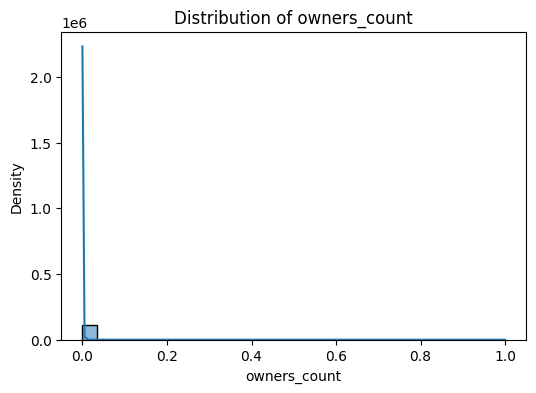

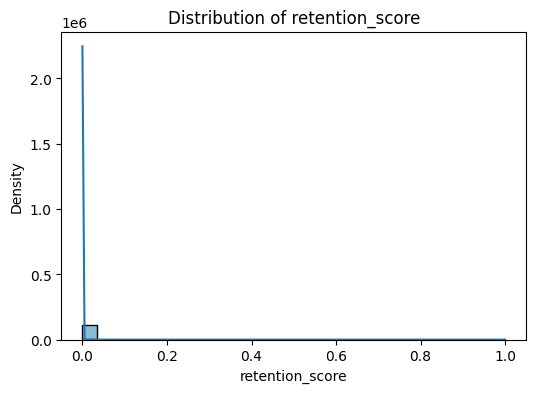

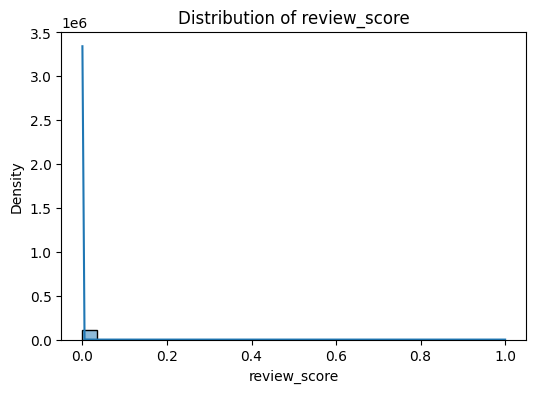

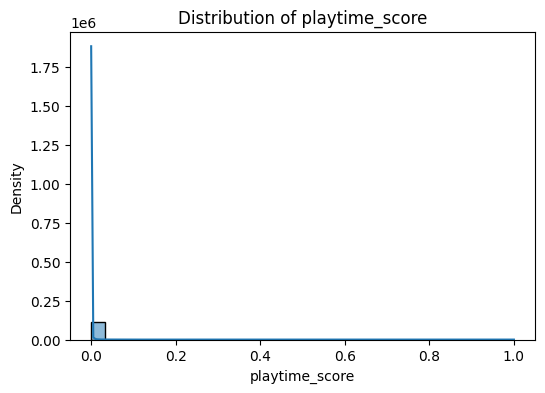

In [22]:
features = ['owners_count', 'retention_score', 'review_score', 'playtime_score']

#  Sanity check: feature distributions
for f in features:
    plt.figure(figsize=(6,4))
    sns.histplot(games_norm[f], bins=30, kde=True)
    plt.title(f"Distribution of {f}")
    plt.xlabel(f)
    plt.ylabel('Density')
    plt.show()

# Sanity Check: Feature Distributions

When examining the distributions of the four main features 
(*owners_count*, *retention_score*, *review_score*, and *playtime_score*), 
a clear pattern emerges:

1. **Heavily Skewed to the Left (Near Zero)**  
   All four features show extreme left-skewness, with the overwhelming majority of games sitting very close to zero.  
   This indicates that most games have low ownership, poor retention, limited playtime, and weaker review ratios.
    
2. **Long Tail of Outliers**  
   Despite the clustering near zero, there are rare but extreme outliers stretching across the entire range up to $1$.  
   These correspond to the exceptional, best-performing games that dominate the market.
    
3. **Implication for Game Success**  
   The distributions reflect the reality of the gaming industry:  
   - Most games launch and quickly fade into obscurity.  
   - Only a handful break through to reach mass adoption, high retention, and lasting engagement.  

In short: the dataset is designed for failure --- most games fail, but the few outliers that succeed are the ones we care about most.

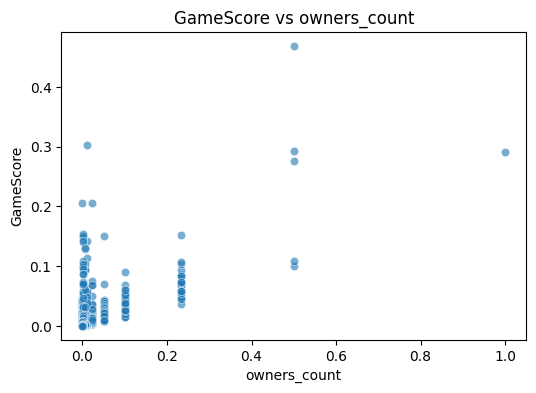

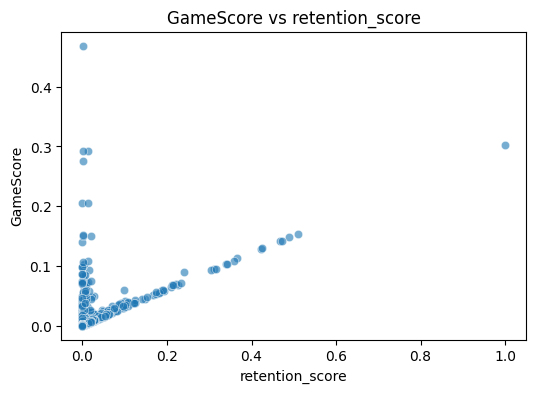

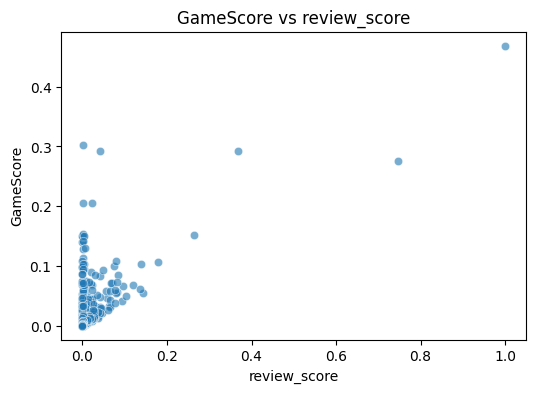

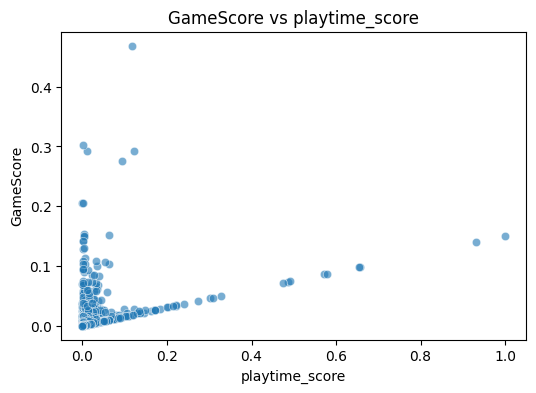

In [23]:
# Sanity check: feature correlations
for f in features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=games_norm[f], y=games_norm['GameScore'], alpha=0.6)
    plt.title(f"GameScore vs {f}")
    plt.xlabel(f)
    plt.ylabel('GameScore')
    plt.show()

# We see that the feature correlations have a linear relationships, with owners_count being sparse/discontinuous

### Sanity Check: Feature Correlations

The scatterplots above compare each feature against our final **GameScore** metric. They serve as a sanity check to confirm that the score behaves in line with real-world expectations about what makes a game successful.

We observe distinct patterns across the four features:

- **Owners count** is extremely skewed: the majority of games have very few owners and correspondingly low GameScores, while only a handful of blockbuster titles stand out with both massive ownership and higher scores. This suggests that ownership mainly separates the runaway hits from the rest, rather than explaining the full distribution.

- **Retention score** shows the clearest positive trend. Games with higher retention systematically achieve higher GameScores, confirming that long-term player engagement is one of the strongest signals of success.

- **Review score** also contributes positively: better-reviewed games tend to score higher, though the relationship is noisier compared to retention. Reviews help distinguish strong titles from weak ones but are not as consistently predictive.

- **Playtime score** behaves similarly to ownership: most games cluster near zero, but a minority with very high playtime achieve higher GameScores. This reflects games that foster deep engagement, even if they are rare.

**Key takeaway:**  
Not all features drive success in the same way. Retention and reviews provide smoother, more linear contributions to the GameScore, while ownership and playtime primarily highlight the outliers — the blockbuster titles that dominate the market. This distribution reflects the reality of the gaming industry: most games achieve only modest success, while a few exceptional titles capture both the market and player attention.


### 10. Gradio App which allows you to play with the weights of the equation and see the results in a DataFrame forat and in a Plotly barchart.

In [26]:
# To run the app simply use the command:
%run ../src/app.py

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


## 11. Conclusions.

Based on some good features we created, we managed to create a BGI based on the most important columns correlating to the game's success.
With that BGI and some custom weights we can now rank the games with the best Index and display them.
The dataset is far from perfect, with some Cleaning and Engineering we managed to create some good features, and based on the Sensitivity and Sanity checks we were able to prove that the Index does work.

Of course there is always room for improvement, some things we can do are:
- Experiment with different features and combinations
- Experiment with a different formula, weights etc.
- Try to pull more data for the games since the APIs don't provide too much
- And there are probably a million things I cannot think of right now that can be improved, so whoever reads this, go ahead and experiment!

But for now... that's it.